In [1]:
!pip install ultralytics
from ultralytics import YOLO

!pip install kagglehub

import os
import shutil
import random
import cv2
import matplotlib.pyplot as plt
from collections import Counter

import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
drive_root = "/content/drive/MyDrive/brain_tumor_project"
os.makedirs(drive_root, exist_ok=True)

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("davidbroberts/brain-tumor-object-detection-datasets")

print("Path to dataset files:", path)

100%|██████████| 12.3M/12.3M [00:00<00:00, 108MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/davidbroberts/brain-tumor-object-detection-datasets/versions/5


In [5]:
dataset_path = os.path.join(path, "coronal_t1wce_2_class")
train_images = os.path.join(dataset_path, "images/train")
train_labels = os.path.join(dataset_path, "labels/train")

In [6]:
# Список файлов в исходном train
raw_label_files = [f for f in os.listdir(train_labels) if f.endswith(".txt")]
raw_image_files = [f for f in os.listdir(train_images) if f.endswith((".jpg", ".png"))]

# ----- 1.1 Проверка формата label-файлов -----
format_errors = 0
bad_format_files = []

for file in raw_label_files:
    with open(os.path.join(train_labels, file)) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                format_errors += 1
                bad_format_files.append(file)
                break

print("Format errors:", format_errors)
print("Files with format errors:", set(bad_format_files))

Format errors: 0
Files with format errors: set()


In [7]:
# ----- 1.2 Проверка координат -----
coord_errors = 0
bad_coord_files = []

for file in raw_label_files:
    with open(os.path.join(train_labels, file)) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                cls = int(parts[0])
                x, y, w, h = map(float, parts[1:])
                if not (0 <= x <= 1 and 0 <= y <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
                    coord_errors += 1
                    bad_coord_files.append(file)
                    break

print("Coordinate errors:", coord_errors)
print("Files with coordinate errors:", set(bad_coord_files))

Coordinate errors: 0
Files with coordinate errors: set()


In [8]:
# ----- 1.3 Проверка пар image <-> label -----
raw_image_names = set(os.path.splitext(f)[0] for f in raw_image_files)
raw_label_names = set(os.path.splitext(f)[0] for f in raw_label_files)

print("Images without labels (RAW):", raw_image_names - raw_label_names)
print("Labels without images (RAW):", raw_label_names - raw_image_names)

Images without labels (RAW): {'72 (12)'}
Labels without images (RAW): set()


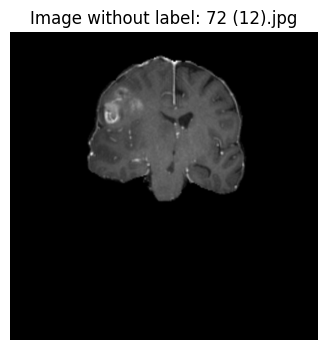

In [9]:
# ----- 1.4 Смотрим пример "проблемной" картинки (если есть images без labels) -----
missing = list(raw_image_names - raw_label_names)

if len(missing) > 0:
    # Пытаемся найти файл с любым расширением
    bad_file = None
    for ext in [".jpg", ".png", ".jpeg"]:
        candidate = missing[0] + ext
        if candidate in raw_image_files:
            bad_file = candidate
            break

    if bad_file is not None:
        img_path = os.path.join(train_images, bad_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(f"Image without label: {bad_file}")
            plt.axis("off")
            plt.show()
        else:
            print("Cannot read bad image:", bad_file)
    else:
        print("Missing image file not found with standard extensions.")
else:
    print("Нет изображений без меток в RAW.")

In [10]:
# ----- 1.5 Содержимое первого label-файла -----
raw_label_files_sorted = sorted(raw_label_files)

if raw_label_files_sorted:
    sample_label = raw_label_files_sorted[0]
    print("Looking at label file:", sample_label)
    with open(os.path.join(train_labels, sample_label)) as f:
        print(f.read())
else:
    print("Нет label-файлов в RAW.")

Looking at label file: 100 (2).txt
0 0.357394 0.321009 0.156103 0.174883


In [11]:
# ----- 1.6 Поиск дубликатов bbox в исходных метках -----
duplicates = []

for file in raw_label_files_sorted:
    seen = set()
    with open(os.path.join(train_labels, file)) as f:
        for line in f:
            if line in seen:
                duplicates.append(file)
                break
            seen.add(line)

print("DUPLICATE BOXES (RAW):", duplicates)

DUPLICATE BOXES (RAW): []


In [12]:
# ----- 1.7 Проверка распределения размеров изображений -----
sizes = {}
for img in raw_image_files:
    im = cv2.imread(os.path.join(train_images, img))
    if im is None:
        continue
    h, w = im.shape[:2]
    sizes[(h, w)] = sizes.get((h, w), 0) + 1

print("Image sizes distribution (RAW):", sizes)

Image sizes distribution (RAW): {(512, 512): 300, (256, 256): 19}


In [13]:
# ----- 1.8 Проверка битых изображений в RAW -----
raw_bad_images = []
for img in raw_image_files:
    path_img = os.path.join(train_images, img)
    im = cv2.imread(path_img)
    if im is None:
        raw_bad_images.append(img)

print("BAD IMAGES (RAW):", raw_bad_images)

BAD IMAGES (RAW): []


In [14]:
clean_root = "/content/dataset_clean"
clean_images = os.path.join(clean_root, "images/train")
clean_labels = os.path.join(clean_root, "labels/train")

os.makedirs(clean_images, exist_ok=True)
os.makedirs(clean_labels, exist_ok=True)

# Указываем явно плохой файл, который надо исключить
bad_image = "72 (12).jpg"
bad_label = "72 (12).txt"

In [15]:
# ----- 2.1 Копируем только хорошие картинки -----
for img in raw_image_files:
    if img != bad_image and img not in raw_bad_images:
        shutil.copy(os.path.join(train_images, img), clean_images)

# ----- 2.2 Копируем только хорошие лейблы -----
for lbl in raw_label_files:
    if lbl != bad_label:
        shutil.copy(os.path.join(train_labels, lbl), clean_labels)

print("Clean dataset created in /content/dataset_clean")


Clean dataset created in /content/dataset_clean


In [16]:
# ----- 2.3 Проверка пар image <-> label в CLEAN -----
clean_img_files = [f for f in os.listdir(clean_images) if f.endswith((".jpg", ".png"))]
clean_lbl_files = [f for f in os.listdir(clean_labels) if f.endswith(".txt")]

clean_image_names = set(os.path.splitext(f)[0] for f in clean_img_files)
clean_label_names = set(os.path.splitext(f)[0] for f in clean_lbl_files)

print("Clean images:", len(clean_img_files))
print("Clean labels:", len(clean_lbl_files))
print("Images without labels (CLEAN):", clean_image_names - clean_label_names)
print("Labels without images (CLEAN):", clean_label_names - clean_image_names)

Clean images: 318
Clean labels: 318
Images without labels (CLEAN): set()
Labels without images (CLEAN): set()


In [17]:
val_images = "/content/dataset_clean/images/val"
val_labels = "/content/dataset_clean/labels/val"

os.makedirs(val_images, exist_ok=True)
os.makedirs(val_labels, exist_ok=True)

all_imgs = sorted(clean_img_files)
random.seed(42)
val_split = 0.2

val_count = int(len(all_imgs) * val_split)
val_files = random.sample(all_imgs, val_count)

for img in val_files:
    base = os.path.splitext(img)[0]
    lbl = base + ".txt"

    # перенос картинки
    shutil.move(os.path.join(clean_images, img), val_images)
    # перенос метки (если есть)
    lbl_src = os.path.join(clean_labels, lbl)
    if os.path.exists(lbl_src):
        shutil.move(lbl_src, val_labels)

print("Validation created:")
print("Train images (after split):", len(os.listdir(clean_images)))
print("Val images:", len(os.listdir(val_images)))

Validation created:
Train images (after split): 255
Val images: 63


In [18]:
val_class_counts = Counter()

for lbl in os.listdir(val_labels):
    if not lbl.endswith(".txt"):
        continue
    with open(os.path.join(val_labels, lbl)) as f:
        for line in f:
            cls = int(line.split()[0])
            val_class_counts[cls] += 1

print("VAL class distribution:", val_class_counts)

VAL class distribution: Counter({1: 37, 0: 29})


In [19]:
labels_dir = clean_labels   # train labels в CLEAN
counter = Counter()

for file in os.listdir(labels_dir):
    if file.endswith(".txt"):
        with open(os.path.join(labels_dir, file), "r") as f:
            for line in f:
                cls = int(line.split()[0])
                counter[cls] += 1

print("Class distribution (CLEAN TRAIN):", counter)

Class distribution (CLEAN TRAIN): Counter({0: 146, 1: 125})


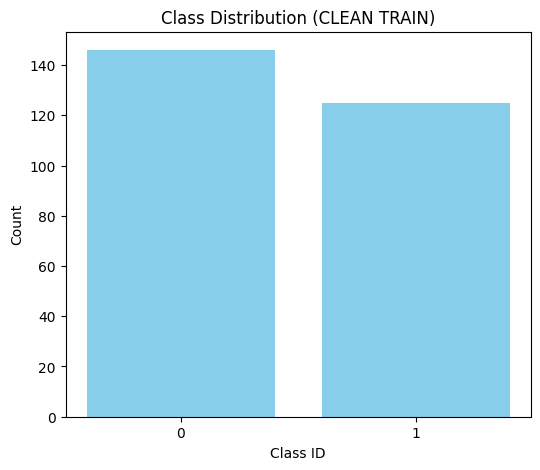

In [20]:
classes = list(counter.keys())
counts = list(counter.values())

plt.figure(figsize=(6, 5))
plt.bar(classes, counts, color='skyblue')
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.title("Class Distribution (CLEAN TRAIN)")
plt.xticks(classes)
plt.show()

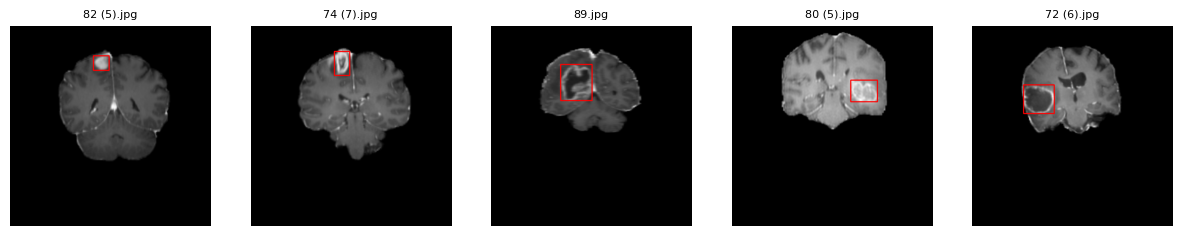

In [21]:
def show_random_grid(n=5):
    files = [f for f in os.listdir(clean_images) if f.endswith((".jpg", ".png"))]
    random_files = random.sample(files, n)

    plt.figure(figsize=(15, 8))

    for i, file in enumerate(random_files, 1):
        img_path = os.path.join(clean_images, file)

        img = cv2.imread(img_path)
        if img is None:
            print("Image not found:", file)
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        label_file = os.path.splitext(file)[0] + ".txt"
        label_path = os.path.join(clean_labels, label_file)

        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls, x, y, bw, bh = map(float, parts)
                        x1 = int((x - bw/2) * w)
                        y1 = int((y - bh/2) * h)
                        x2 = int((x + bw/2) * w)
                        y2 = int((y + bh/2) * h)
                        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.title(file, fontsize=8)
        plt.axis("off")

show_random_grid(5)


In [22]:
empty_boxes = []

for file in os.listdir(clean_labels):
    if not file.endswith(".txt"):
        continue
    with open(os.path.join(clean_labels, file)) as f:
        for line in f:
            parts = line.split()
            if len(parts) != 5:
                continue
            cls = int(parts[0])
            x, y, w, h = map(float, parts[1:])
            if w == 0 or h == 0:
                empty_boxes.append(file)
                break

print("EMPTY BOUNDING BOXES (CLEAN TRAIN):", empty_boxes)

EMPTY BOUNDING BOXES (CLEAN TRAIN): []


In [23]:
bad_images_clean = []

for img in os.listdir(clean_images):
    path_img = os.path.join(clean_images, img)
    im = cv2.imread(path_img)
    if im is None:
        bad_images_clean.append(img)

print("BAD IMAGES (CLEAN TRAIN):", bad_images_clean)

BAD IMAGES (CLEAN TRAIN): []


In [24]:
shutil.copytree(                                        # используем для гугл колаба
    "/content/dataset_clean",
    os.path.join(drive_root, "dataset_clean"),
    dirs_exist_ok=True
)

'/content/drive/MyDrive/brain_tumor_project/dataset_clean'

In [25]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [26]:
data_yaml = """
path: /content/dataset_clean
train: images/train
val: images/val

nc: 2
names: ['negative', 'positive']
"""

with open("/content/dataset_clean/data.yaml", "w") as f:
    f.write(data_yaml)

print("YAML created.")

YAML created.


In [27]:
model1 = YOLO("yolo11m.pt")

In [28]:
results = model1.train(
    data="/content/dataset_clean/data.yaml",
    name="brain_tumor_v1",
    epochs=200,
    imgsz=640,
    batch=8,
    device=DEVICE,
    patience=50,
    cos_lr=True,
    close_mosaic=20,
    warmup_epochs=5,
    amp=True,
    seed=42,
    lr0=0.0005,            # меньше learning rate
    weight_decay=0.0001,   # чуть больше регуляризация
)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=20, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/dataset_clean/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=brain_tumor_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=50, pe

In [29]:
model2 = YOLO("yolo11m.pt")
model2.train(
    data="/content/dataset_clean/data.yaml",
    name="brain_tumor_y11m_stable",
    epochs=250,
    batch=8,                 # меньше батч → меньше переобучение
    imgsz=640,

    optimizer="SGD",
    momentum=0.937,
    weight_decay=0.0005,

    lr0=0.00025,            # ниже learning rate
    lrf=0.01,

    warmup_epochs=15,       # больше warmup
    close_mosaic=50,        # mosaic дольше открыт → больше разнообразия
    cos_lr=True,
    patience=80,

    conf=0.001,             # НЕ отбрасывать слабые боксы
    iou=0.3,                # увеличить чувствительность на validation

    device=DEVICE
)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=30, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/dataset_clean/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0004, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=brain_tumor_v2, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=70, pe

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dc777e05f40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [36]:
model3 = YOLO("yolo11l.pt")

results = model3.train(
    data="/content/dataset_clean/data.yaml",
    name="brain_tumor_v3_stable",
    epochs=220,           # безопасная длина обучения
    batch=8,
    imgsz=640,           # 768 слишком тяжело для L — ставим стабильный размер
    # Улучшенная устойчивость обучения
    lr0=0.00025,         # мягкий learning rate
    weight_decay=0.0001,
    warmup_epochs=10,    # мягкий старт, снижает риск переобучения
    cos_lr=True,
    # Mosaic
    close_mosaic=25,     # НЕ выше 30 для маленького датасета
    # Early stopping
    patience=70,
    # Анти-"обнуление боксов" — критически важно
    conf=0.001,          # разрешить слабые детекции, чтобы модель не “молчала”
    iou=0.3,             # делает модель чувствительнее при валидации
    # Аугментации — лёгкие, без риска сломать паттерны
    augment=True,
    hsv_h=0.015,
    hsv_s=0.5,
    hsv_v=0.4,
    degrees=10,
    translate=0.10,
    scale=0.12,
    fliplr=0.5,
    flipud=0.1,
    device=DEVICE,
)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=25, cls=0.5, compile=False, conf=0.001, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/dataset_clean/data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=220, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5, hsv_v=0.4, imgsz=640, int8=False, iou=0.3, keras=False, kobj=1.0, line_width=None, lr0=0.00025, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=brain_tumor_v3_stable, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience

KeyboardInterrupt: 

In [32]:
model4 = YOLO("yolo11m.pt")
model4.train(
    data="/content/dataset_clean/data.yaml",
    name="brain_tumor_v4",
    epochs=200,
    batch=8,
    imgsz=640,
    augment=True,
    hsv_h=0.015,
    hsv_s=0.4,
    hsv_v=0.4,
    degrees=10,
    translate=0.1,
    scale=0.15,
    fliplr=0.5,
    flipud=0.1,
    mixup=0.1,

    close_mosaic=20,
    lr0=0.00045,
    weight_decay=0.0001,
    warmup_epochs=8,
    cos_lr=True,
    patience=60,

    iou=0.3,       # ← добавь
    conf=0.001,    # ← добавь

    device=DEVICE,
)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=20, cls=0.5, compile=False, conf=0.001, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/dataset_clean/data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.4, imgsz=640, int8=False, iou=0.3, keras=False, kobj=1.0, line_width=None, lr0=0.00045, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=brain_tumor_v42, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=60, p

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dc5c47650a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
model5 = YOLO("yolo11l.pt")

results = model5.train(
    data="/content/dataset_clean/data.yaml",
    name="brain_tumor_v5",
    epochs=250,
    batch=8,
    imgsz=640,

    # стабильность
    lr0=0.00035,
    weight_decay=0.0001,
    warmup_epochs=8,
    cos_lr=True,
    patience=80,

    # корректная оценка
    conf=0.01,
    iou=0.45,

    # медицинские аугментации (безопасные)
    augment=True,
    hsv_h=0.005,
    hsv_s=0.10,
    hsv_v=0.10,
    degrees=5,
    translate=0.05,
    scale=0.05,
    fliplr=0.2,
    flipud=0.0,      # НЕЛЬЗЯ В MED!!!
    mixup=0.0,

    close_mosaic=15,
    device=DEVICE,
)

In [34]:
url = "https://prod-images-static.radiopaedia.org/images/22581/6aec5e1ad33ea1775e6fa56d5fa5b3_big_gallery.jpeg"

results = model.predict(url, conf=0.6)


WARNING ⚠️ Download failure, retrying 1/3 https://prod-images-static.radiopaedia.org/images/22581/6aec5e1ad33ea1775e6fa56d5fa5b3_big_gallery.jpeg... HTTP Error 403: Forbidden
image 1/1 /content/6aec5e1ad33ea1775e6fa56d5fa5b3_big_gallery.jpeg: 640x608 1 negative, 55.4ms
Speed: 3.7ms preprocess, 55.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


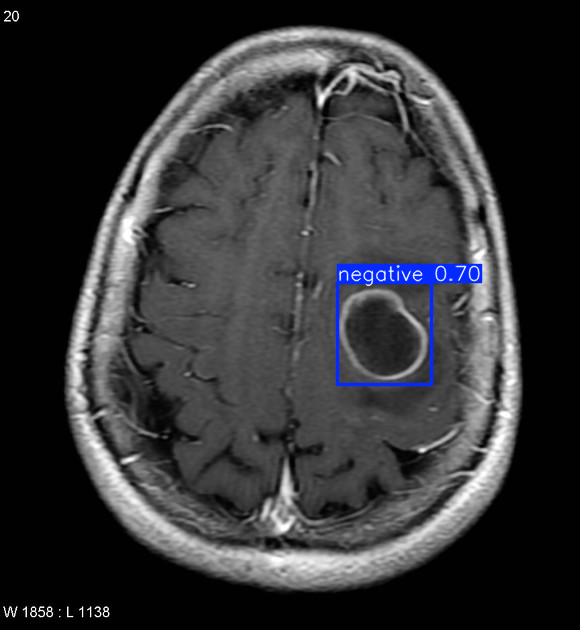

In [35]:
# Process results list
for result in results:
    boxes = result.boxes  # bbox нужен для детекции
    masks = result.masks  # Маска нужна для сегментации
    keypoints = result.keypoints  # Для определения позы
    probs = result.probs  # Для классификации найденного объекта
    obb = result.obb  # Ориентированный bbox
    result.show()  # display to screen

In [ ]:
import pandas as pd
import os, yaml

paths = [
    "/content/runs/detect/brain_tumor_v1",
    "/content/runs/detect/brain_tumor_v2",
    "/content/runs/detect/brain_tumor_v3",
    "/content/runs/detect/brain_tumor_v4",
]

results = []

for p in paths:
    metrics_file = os.path.join(p, "results.yaml")
    if os.path.exists(metrics_file):
        with open(metrics_file, "r") as f:
            data = yaml.safe_load(f)
            results.append({
                "model": p.split("/")[-1],
                "precision": data.get("metrics/precision(B)", None),
                "recall": data.get("metrics/recall(B)", None),
                "mAP50": data.get("metrics/mAP50(B)", None),
                "mAP50-95": data.get("metrics/mAP50-95(B)", None),
                "best_epoch": data.get("epoch", None),
            })

df = pd.DataFrame(results)
df.sort_values("mAP50", ascending=False)